In [1]:
import os
import cv2
import pickle
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Sequential, datasets, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import utils as np_utils
from tensorflow.keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, BatchNormalization,Dense, Dropout, Activation, Flatten

In [2]:
### Import dataset
def unpickle(file):
    import pickle
    with open(file, 'rb') as p:
        dict = pickle.load(p, encoding='bytes')
    return dict

meta = unpickle("./cifar-100-python/meta")
train = unpickle("./cifar-100-python/train")
#test = unpickle("C:/Users/Administrator/Desktop/5318 Group/cifar-100-python/test")

In [3]:
### Split training set
from sklearn.model_selection import train_test_split

train_x = train[b'data']
train_y = train[b'coarse_labels'] # Use coarse_labels for classification
#test_x = test[b'data']
#test_y = test[b'coarse_labels']

train_xs, test_xs= train_test_split(train_x, test_size=0.1, random_state=0, shuffle=True) # 10-kFold
train_ys, test_ys= train_test_split(train_y, test_size=0.1, random_state=0, shuffle=True)

In [4]:
### Transfer images into RGB
train_x=train_x.reshape(-1,3,32,32)
train_x=np.rollaxis(train_x, 1, 4)
train_xs=train_xs.reshape(-1,3,32,32)
train_xs=np.rollaxis(train_xs, 1, 4)
test_xs=test_xs.reshape(-1,3,32,32)
test_xs=np.rollaxis(test_xs, 1, 4)
#test_x=test_x.reshape(-1,3,32,32)
#test_x=np.rollaxis(test_x, 1, 4)

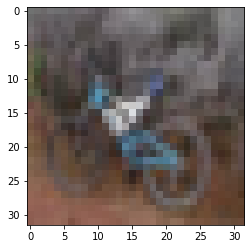

In [5]:
### Picture conversion example
index = 10
img_gray = train_xs[index]
plt.figure()
plt.imshow(img_gray)

In [6]:
### Data preprocessing by using Normalization
def preprocess(x, y):
    x = tf.cast(x, dtype=tf.float32) / 255.
    y = tf.cast(y, dtype=tf.int32)
    
    return x, y

In [25]:
### Build the dataset object
train_db = tf.data.Dataset.from_tensor_slices((train_xs, train_ys))
train_db = train_db.map(preprocess).batch(225) ## Pack bulk data into a batch
test_db = tf.data.Dataset.from_tensor_slices((test_xs, test_ys))
test_db = test_db.map(preprocess).batch(225)

In [8]:
### Construct the first half of the convolutional network
def convoluation(num): ## Convolational layer
    return layers.Conv2D(num, kernel_size=[3, 3], padding="same", activation=tf.nn.relu)

def pool(): ## Pooling layer
    return layers.MaxPool2D(pool_size=[2, 2], strides=2, padding='same')

def conv_combo(conv, num):
    conv.add(convoluation(num))
    conv.add(layers.Dropout(0.5)) ## Dropout prevent overfitting
    conv.add(convoluation(num))
    conv.add(pool())

In [9]:
### Convolutional layer pipeline
def conv_net(num1, num2, num3):

    conv_net = Sequential() ## Build convolutional network object
    
    conv_combo(conv_net, num1)
    conv_combo(conv_net, num2)
    conv_combo(conv_net, num2)
    conv_combo(conv_net, num3)
    conv_combo(conv_net, num3)
    
    return conv_net

In [10]:
### Custom Dense layer (Full-connected layer)
def dense(num):
    return layers.Dense(num, activation=tf.nn.relu)

def fc_net(num1, num2, num3):
    
    fc_net = Sequential() ## Build full-connected network object
    
    dense(num1)
    dense(num2)
    dense(num3)
    
    return fc_net

In [11]:
Conv_net = conv_net(64,128,256)
Fc_net = fc_net(128,64,50)

### Set the input tensor shape of the model
Conv_net.build(input_shape=[None, 32, 32, 3])
Fc_net.build(input_shape=[None, 256])
optimizer = optimizers.Adam(lr=1e-4) ## Set up the optimizer by using Adam

### Use one variable to represent the weights in the two models to facilitate subsequent weight updates
variables = Conv_net.trainable_variables + Fc_net.trainable_variables

In [12]:
### Combine convolutional network and fully connected network
def fullConv():
    out = Conv_net(x)
    out = tf.reshape(out, [-1, 256]) ## Full-connected layer：[b, 256] => [b, 50]
    logits = Fc_net(out)
    
    return out, logits

In [13]:
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix

0 0 loss: 2.0769271850585938
0 100 loss: 2.336489200592041
0 acc: 0.3812
precision: 0.31
recall: 0.37


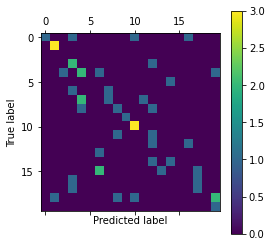

time: 389.52574491500854
1 0 loss: 2.015378713607788
1 100 loss: 2.2560057640075684
1 acc: 0.394
precision: 0.31595238095238093
recall: 0.3783333333333333


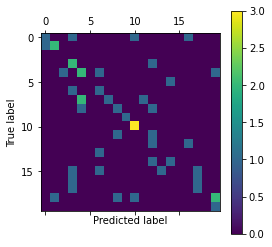

time: 433.2999515533447
2 0 loss: 1.9617565870285034
2 100 loss: 2.187533378601074
2 acc: 0.4056
precision: 0.3526315789473684
recall: 0.4043859649122807


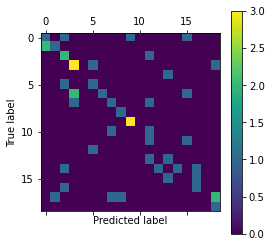

time: 390.6489384174347
3 0 loss: 1.9024325609207153
3 100 loss: 2.115959882736206
3 acc: 0.4108
precision: 0.3614035087719298
recall: 0.4043859649122807


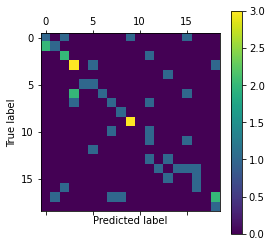

time: 391.5174255371094
4 0 loss: 1.8542617559432983
4 100 loss: 2.0399882793426514
4 acc: 0.4176
precision: 0.39473684210526305
recall: 0.4307017543859649


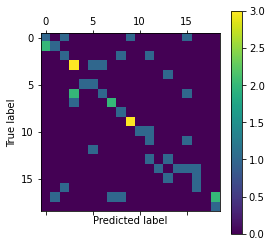

time: 391.59459114074707
5 0 loss: 1.7857165336608887
5 100 loss: 1.9828367233276367
5 acc: 0.4188
precision: 0.40263157894736834
recall: 0.4333333333333333


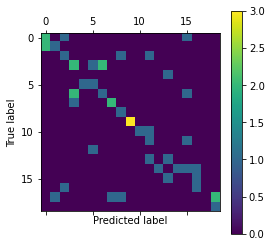

time: 391.0738980770111
6 0 loss: 1.7415560483932495
6 100 loss: 1.9135388135910034
6 acc: 0.4274
precision: 0.3783333333333333
recall: 0.4116666666666666


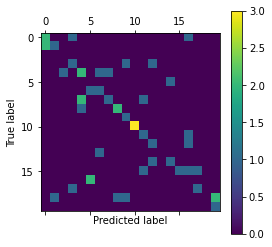

time: 390.4742941856384
7 0 loss: 1.6850825548171997
7 100 loss: 1.8720232248306274
7 acc: 0.4322
precision: 0.42416666666666664
recall: 0.3991666666666666


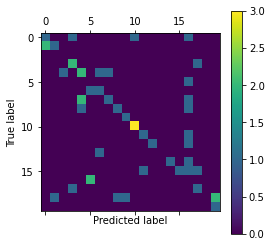

time: 391.715389251709
8 0 loss: 1.628441572189331
8 100 loss: 1.8793725967407227
8 acc: 0.431
precision: 0.3991666666666666
recall: 0.38249999999999995


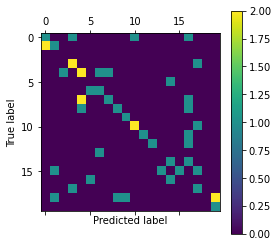

time: 390.8338794708252
9 0 loss: 1.6131157875061035
9 100 loss: 1.8790680170059204
9 acc: 0.4306
precision: 0.3460526315789474
recall: 0.39999999999999997


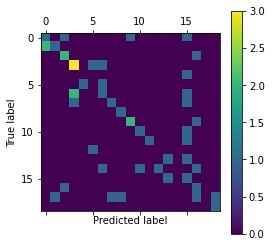

time: 390.96272230148315
10 0 loss: 1.556081771850586
10 100 loss: 1.7501811981201172
10 acc: 0.438
precision: 0.3942982456140351
recall: 0.4157894736842105


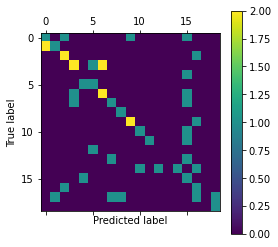

time: 390.11434626579285
11 0 loss: 1.4579405784606934
11 100 loss: 1.682415246963501
11 acc: 0.4358
precision: 0.425438596491228
recall: 0.4307017543859649


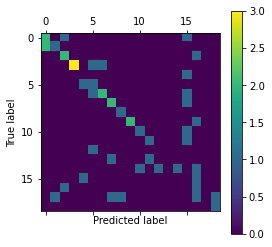

time: 390.2777111530304
12 0 loss: 1.4104259014129639
12 100 loss: 1.5991122722625732
12 acc: 0.4382
precision: 0.4285087719298245
recall: 0.4596491228070175


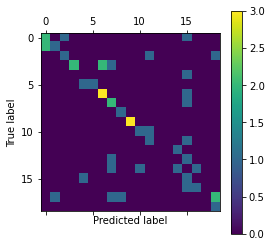

time: 391.0827867984772
13 0 loss: 1.396302342414856
13 100 loss: 1.5239731073379517
13 acc: 0.44
precision: 0.40350877192982454
recall: 0.4263157894736842


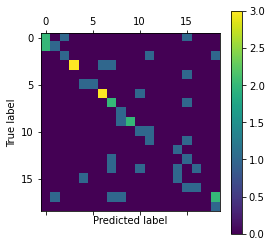

time: 391.93780970573425
14 0 loss: 1.3577544689178467
14 100 loss: 1.473650336265564
14 acc: 0.4234
precision: 0.3824561403508772
recall: 0.4131578947368421


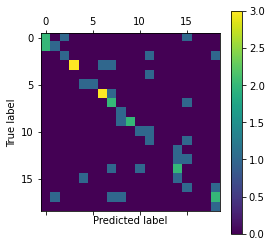

time: 391.8041021823883
15 0 loss: 1.349432110786438
15 100 loss: 1.430134654045105
15 acc: 0.4374
precision: 0.42894736842105263
recall: 0.40789473684210525


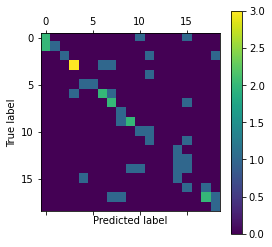

time: 390.6732897758484
16 0 loss: 1.122106671333313
16 100 loss: 1.0281963348388672
16 acc: 0.4446
precision: 0.41833333333333333
recall: 0.3958333333333333


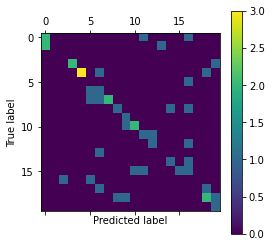

time: 391.2997260093689
17 0 loss: 0.9689547419548035
17 100 loss: 1.0911566019058228
17 acc: 0.4466
precision: 0.4276315789473684
recall: 0.3824561403508772


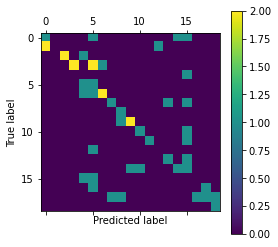

time: 391.1187345981598
18 0 loss: 0.8466038703918457
18 100 loss: 1.1750184297561646
18 acc: 0.442
precision: 0.39880952380952384
recall: 0.3158333333333333


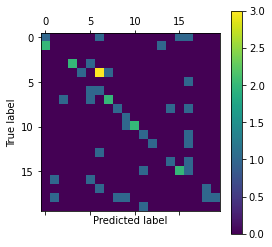

time: 391.7217662334442
19 0 loss: 0.7377486228942871
19 100 loss: 1.1904628276824951
19 acc: 0.4332
precision: 0.3708333333333333
recall: 0.3308333333333333


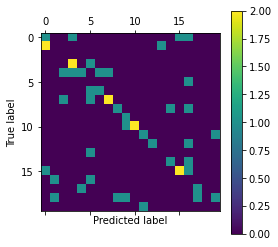

time: 390.8563117980957
20 0 loss: 0.7158286571502686
20 100 loss: 0.8557789921760559
20 acc: 0.4134
precision: 0.3726190476190476
recall: 0.29333333333333333


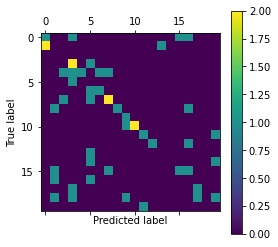

time: 390.31234192848206
21 0 loss: 0.7916565537452698
21 100 loss: 0.6886386871337891
21 acc: 0.4058
precision: 0.4133333333333333
recall: 0.30166666666666664


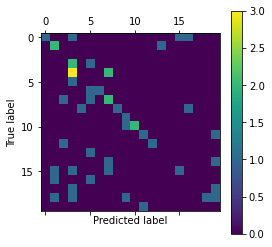

time: 391.27245712280273
22 0 loss: 0.8819038271903992
22 100 loss: 0.7037360072135925
22 acc: 0.4188
precision: 0.35357142857142854
recall: 0.31166666666666665


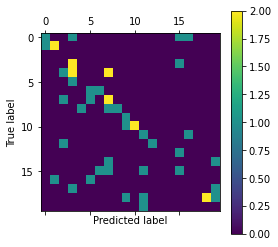

time: 391.9737820625305
23 0 loss: 0.7942832708358765
23 100 loss: 0.6726353168487549
23 acc: 0.4136
precision: 0.2488095238095238
recall: 0.24416666666666664


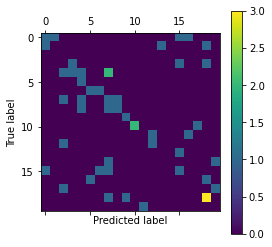

time: 392.3834283351898
24 0 loss: 0.7501611113548279
24 100 loss: 0.6508456468582153
24 acc: 0.4248
precision: 0.4083333333333333
recall: 0.4066666666666666


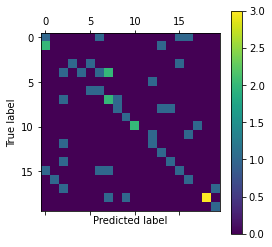

time: 391.0252947807312
25 0 loss: 0.536148190498352
25 100 loss: 0.7096322178840637
25 acc: 0.434
precision: 0.37666666666666665
recall: 0.35333333333333333


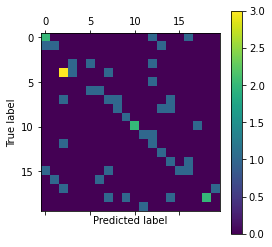

time: 390.67512226104736
26 0 loss: 0.44946807622909546
26 100 loss: 0.6174855828285217
26 acc: 0.4328
precision: 0.46416666666666667
recall: 0.4033333333333333


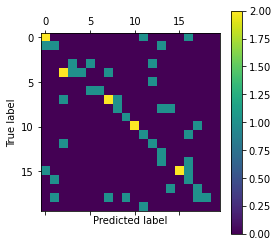

time: 390.3226602077484
27 0 loss: 0.4807164967060089
27 100 loss: 0.4810504913330078
27 acc: 0.4142
precision: 0.4312499999999999
recall: 0.41


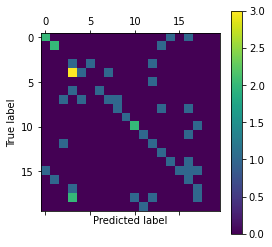

time: 390.7807548046112
28 0 loss: 0.5204387903213501
28 100 loss: 0.3591269552707672
28 acc: 0.4144
precision: 0.4871428571428571
recall: 0.40083333333333326


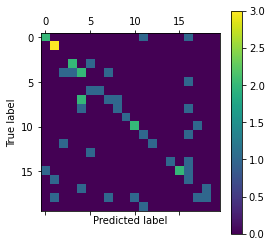

time: 392.09429264068604
29 0 loss: 0.47123366594314575
29 100 loss: 0.41183796525001526
29 acc: 0.42
precision: 0.41500000000000004
recall: 0.35250000000000004


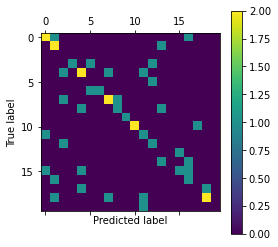

time: 390.73561358451843
30 0 loss: 0.38997822999954224
30 100 loss: 0.4773077666759491
30 acc: 0.4096
precision: 0.38666666666666666
recall: 0.3425


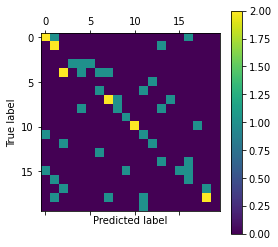

time: 390.3911225795746
31 0 loss: 0.4734726846218109
31 100 loss: 0.5332818627357483
31 acc: 0.4322
precision: 0.39
recall: 0.3625


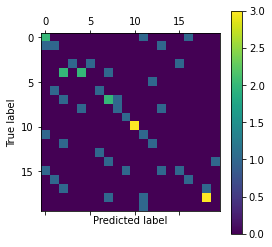

time: 391.62230706214905
32 0 loss: 0.3345898687839508
32 100 loss: 0.4636366069316864
32 acc: 0.4378
precision: 0.3958333333333333
recall: 0.35416666666666663


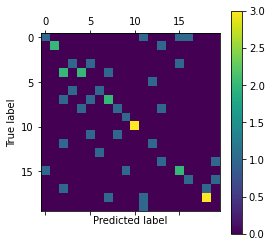

time: 390.6860284805298
33 0 loss: 0.28882211446762085
33 100 loss: 0.3584255278110504
33 acc: 0.432
precision: 0.36
recall: 0.3441666666666666


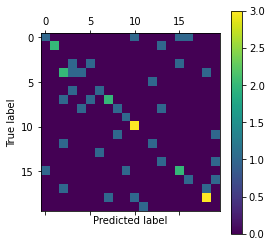

time: 390.69677233695984
34 0 loss: 0.22374507784843445
34 100 loss: 0.26711419224739075
34 acc: 0.4314
precision: 0.36333333333333334
recall: 0.3466666666666666


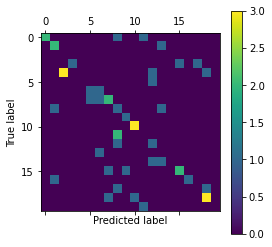

time: 390.9425473213196
35 0 loss: 0.20095334947109222
35 100 loss: 0.24997273087501526
35 acc: 0.4224
precision: 0.2925
recall: 0.32166666666666666


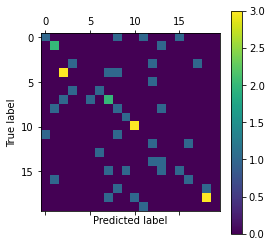

time: 390.91431975364685
36 0 loss: 0.2708527147769928
36 100 loss: 0.2130279690027237
36 acc: 0.4316
precision: 0.35464285714285715
recall: 0.37


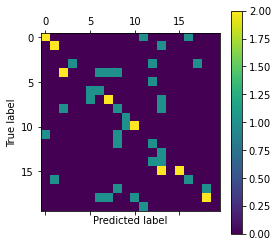

time: 390.9531533718109
37 0 loss: 0.22961030900478363
37 100 loss: 0.12906944751739502
37 acc: 0.4264
precision: 0.3575
recall: 0.32


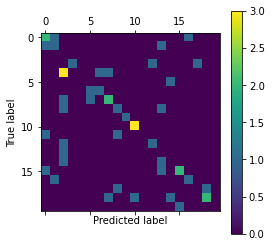

time: 391.4883131980896
38 0 loss: 0.2675114870071411
38 100 loss: 0.11679534614086151
38 acc: 0.4318
precision: 0.39166666666666666
recall: 0.2783333333333333


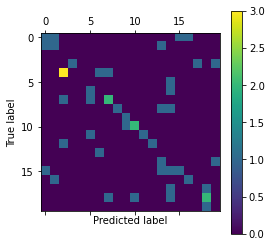

time: 391.2310903072357
39 0 loss: 0.14042596518993378
39 100 loss: 0.11906402558088303
39 acc: 0.44
precision: 0.4458333333333333
recall: 0.29250000000000004


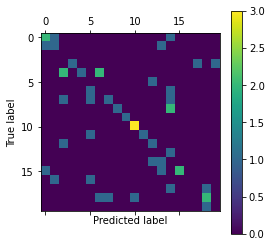

time: 391.5837118625641
40 0 loss: 0.10276993364095688
40 100 loss: 0.16773265600204468
40 acc: 0.4286
precision: 0.42638888888888893
recall: 0.3466666666666667


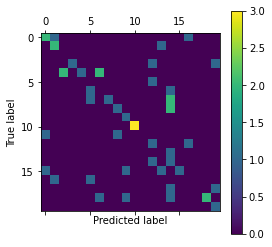

time: 392.3932409286499
41 0 loss: 0.12939272820949554
41 100 loss: 0.26618292927742004
41 acc: 0.4456
precision: 0.44333333333333325
recall: 0.40083333333333326


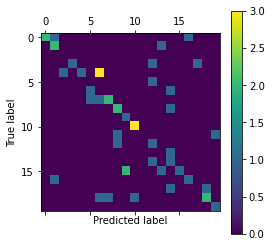

time: 391.7210125923157
42 0 loss: 0.05744611471891403
42 100 loss: 0.17700406908988953
42 acc: 0.444
precision: 0.3958333333333333
recall: 0.3591666666666667


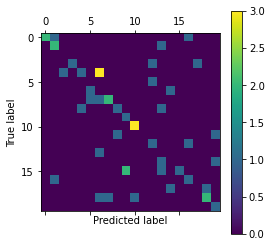

time: 391.1376359462738
43 0 loss: 0.07990077883005142
43 100 loss: 0.17604801058769226
43 acc: 0.4448
precision: 0.5125
recall: 0.44666666666666666


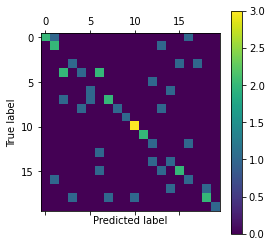

time: 391.3467173576355
44 0 loss: 0.05727475509047508
44 100 loss: 0.2045263648033142
44 acc: 0.4472
precision: 0.4225
recall: 0.3591666666666667


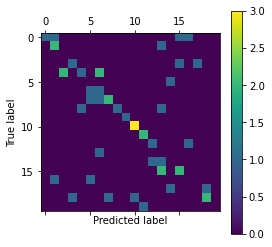

time: 390.8178679943085
45 0 loss: 0.05300131067633629
45 100 loss: 0.17279775440692902
45 acc: 0.4396
precision: 0.3375
recall: 0.30083333333333334


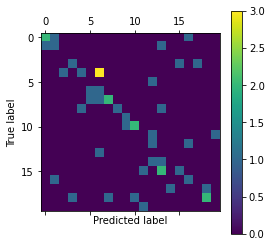

time: 391.18335127830505
46 0 loss: 0.05204922705888748
46 100 loss: 0.09464001655578613
46 acc: 0.4334
precision: 0.36666666666666664
recall: 0.32333333333333336


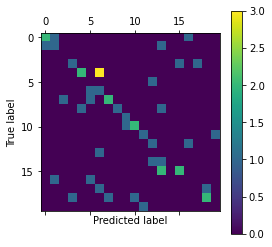

time: 390.98606419563293
47 0 loss: 0.09839007258415222
47 100 loss: 0.06288253515958786
47 acc: 0.4332
precision: 0.36666666666666664
recall: 0.2758333333333333


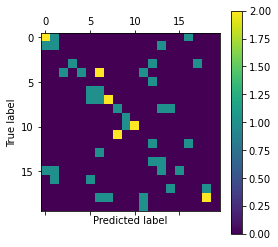

time: 392.0361907482147
48 0 loss: 0.07575322687625885
48 100 loss: 0.06011558696627617
48 acc: 0.4376
precision: 0.36297619047619045
recall: 0.28833333333333333


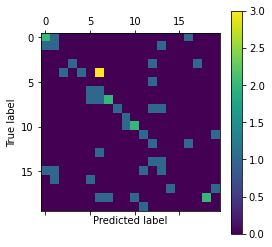

time: 391.9675340652466
49 0 loss: 0.09262267500162125
49 100 loss: 0.05453300103545189
49 acc: 0.427
precision: 0.3258333333333333
recall: 0.3075


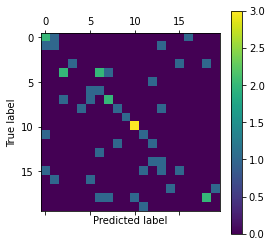

time: 392.3570981025696


In [31]:
### Start training
import time ## Time counting

for epoch in range(50): ## 50 epochs in total
    
    cpu_start = time.time() ## Time start
    
    for step, (x,y) in enumerate(train_db):
        with tf.GradientTape() as tape:
            
            out, logits = fullConv()
            y_onehot = tf.one_hot(y, depth=256)
        
            ## Use cross entropy to calculate loss
            loss = tf.losses.categorical_crossentropy(y_onehot, logits, from_logits=True)
            loss = tf.reduce_mean(loss)
        
            grads = tape.gradient(loss, variables) ## Compute gradient
            optimizer.apply_gradients(zip(grads, variables)) ## Gradient update
        
            if step %100 == 0:
                print(epoch, step, 'loss:', float(loss)) ## Print the loss information
    
    ## Test: Test the accuracy of each data set after training
    total_num = 0
    total_correct = 0
    
    for x,y in test_db:
      
        out, logits = fullConv()
        prob = tf.nn.softmax(logits, axis=1)
        
        ## Prediction
        pred = tf.argmax(prob, axis=1) ## !!!The data returned is in int64 format!!!
        pred = tf.cast(pred, dtype=tf.int32) ## Transfer: int64 => int32

        ## Count the correct number
        correct = tf.cast(tf.equal(pred, y), dtype=tf.int32)
        correct_1 = tf.reduce_sum(correct) ## Correct data number

        total_num += x.shape[0]
        total_correct += int(correct_1)
    
    ## Accuracy
    acc = total_correct / total_num
    print(epoch, 'acc:', acc)
    
    ## Precision
    prec = precision_score(y, pred, average='macro')
    print('precision:', prec)
    
    ## Recall
    recall = recall_score(y, pred, average='macro')
    print('recall:', recall)
    
    ## Confusion matrix
    def confusion_matrix_plot_1(y_text, y_predict):
        matrix = confusion_matrix(y_text, y_predict)
        plt.matshow(matrix)
        plt.colorbar()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        
        return plt
    
    ## Print out confusion matrix image
    confusion_matrix_plot_1(y, pred).show()
    
    cpu_end = time.time()
    print('time:', cpu_end - cpu_start) ## Time end